## Autoregressive Models with Inflation Data Only

In [23]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sml
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import datetime
import shap
from pmdarima import auto_arima

In [24]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

In [25]:
# inflation (2011 - Mar 2025)
inflation_data = pd.read_csv('./yoy_inflation_till_March_2025.csv')
inflation_data.head()

,Month,Year-on-Year Change (%)
0,Jan '11,12.079665
1,Feb '11,11.099837
2,Mar '11,12.779128
3,Apr '11,11.291282
4,May '11,12.352128


In [26]:
# Convert string to datetime and then format
def format_date(date_str):
    date_obj = datetime.datetime.strptime(date_str, '%Y-%m')
    return date_obj.strftime('%b \'%y')

In [27]:
inflation_data = inflation_data.rename(columns={'Year-on-Year Change (%)': 'Inflation rate'})
inflation_data['Month'] = pd.to_datetime(inflation_data['Month'], format='%b \'%y')
inflation_data.head()

,Month,Inflation rate
0,2011-01-01,12.079665
1,2011-02-01,11.099837
2,2011-03-01,12.779128
3,2011-04-01,11.291282
4,2011-05-01,12.352128


In [28]:
# calculate eval metrics
def calculate_metrics(y_true, y_pred):

    # Convert inputs to numpy arrays
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()

    r_squared = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2)) * 100
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2) )
    
    return r_squared, mse, rmse, rmspe, mae, mape, smape



In [29]:
# split the data into train and test sets

split_date = '2024-01-01'  # Define the split date

train_data = inflation_data[inflation_data['Month'] < split_date]
test_data = inflation_data[inflation_data['Month'] >= split_date]
# display the first few rows of the train and test DataFrames
display(train_data)
display(test_data)

# print the shape of the train and test data
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

,Month,Inflation rate
0,2011-01-01,12.079665
1,2011-02-01,11.099837
2,2011-03-01,12.779128
3,2011-04-01,11.291282
4,2011-05-01,12.352128
...,...,...
151,2023-08-01,25.797840
152,2023-09-01,26.715832
153,2023-10-01,27.329722
154,2023-11-01,28.200174


,Month,Inflation rate
156,2024-01-01,29.899059
157,2024-02-01,31.698232
158,2024-03-01,33.201433
159,2024-04-01,33.694665
160,2024-05-01,33.953014
161,2024-06-01,34.191672
162,2024-07-01,33.395252
163,2024-08-01,32.150132
164,2024-09-01,32.696276
165,2024-10-01,33.876872


Train data shape: (156, 2)
Test data shape: (15, 2)


In [30]:
y_train = train_data['Inflation rate']
print(f"y_train shape: {y_train.shape}")

y_test = test_data['Inflation rate']
print(f"y_test shape: {y_test.shape}")

y_train shape: (156,)
y_test shape: (15,)


### Pre-modeling analysis

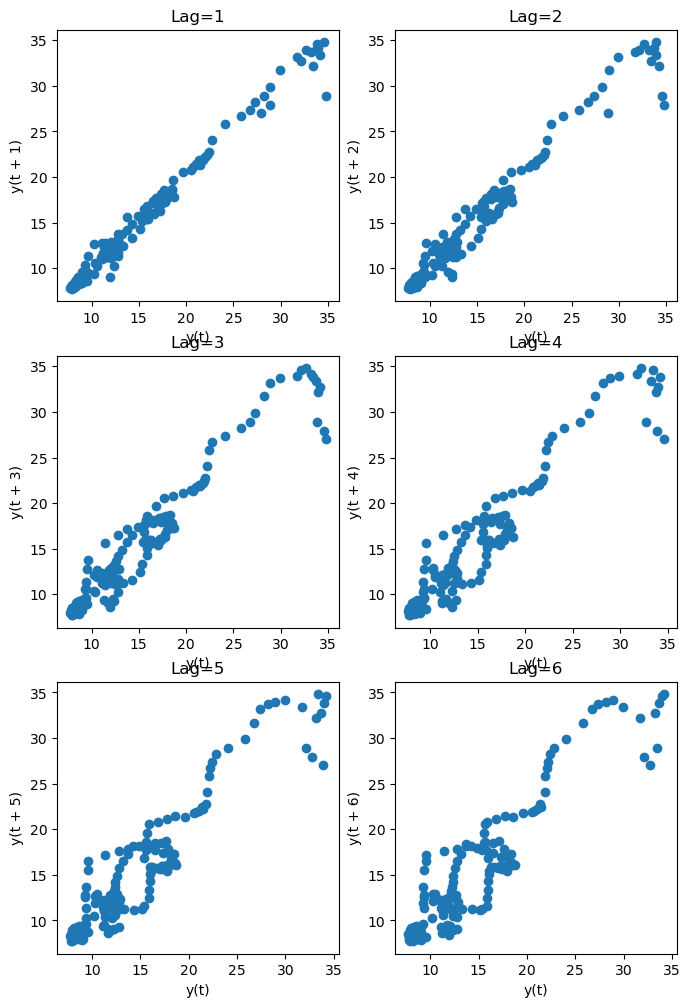

In [31]:
from pandas.plotting import lag_plot

fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('NG Inflation Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(inflation_data['Inflation rate'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.show()


Interpretation Summary:
The time series is not random.

There is strong short-term autocorrelation, especially at Lag=1.

The decay of correlation suggests the presence of trend or long-memory behavior.

Non-linearity in higher lags implies the data may benefit from non-linear modeling techniques (e.g., ARIMA with transformations, or machine learning models).

**Since the Autocorrelation plots are not fully linear, we will let pdarima determine the proper lag term to use**

In [32]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")

Estimated differencing term: 1


In [33]:
# Fit AR model with d=1 but allowing ARIMA model to explore for p and q values to is best suited

ar_baseline = auto_arima(
                        y_train, 
                        d=n_diffs, 
                        seasonal=False, 
                        stepwise=True,
                        suppress_warnings=True, 
                        error_action="ignore", 
                        max_p=36,
                        max_order=None,
                        information_criterion='aic',
                        # information_criterion='bic',
                        trace=True
                    )

print(f'(p, d, q): {ar_baseline.order}')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=291.170, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=313.829, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=307.060, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=310.725, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=316.007, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=290.962, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=294.094, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=295.368, Time=0.03 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=292.594, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=295.805, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=289.455, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=287.799, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=289.565, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=291.340, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=287.1

In [34]:
model = ar_baseline  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

# Calculate metrics for the naive baseline
metrics_test_ar_baseline = calculate_metrics(y_test, forecasts)

# Create a DataFrame to store the metrics
metrics_test_ar_baseline_df = pd.DataFrame({
    'Model': ['AR Baseline'],
    'R-squared': [metrics_test_ar_baseline[0]],
    'MSE': [metrics_test_ar_baseline[1]],
    'RMSE': [metrics_test_ar_baseline[2]],
    'RMSPE': [metrics_test_ar_baseline[3]],
    'MAE': [metrics_test_ar_baseline[4]],
    'MAPE': [metrics_test_ar_baseline[-2]],
    'SMAPE': [metrics_test_ar_baseline[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_baseline_df = metrics_test_ar_baseline_df.round(2)
display(metrics_test_ar_baseline_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline,0.45,3.24,1.8,6.11,1.09,3.55,3.42


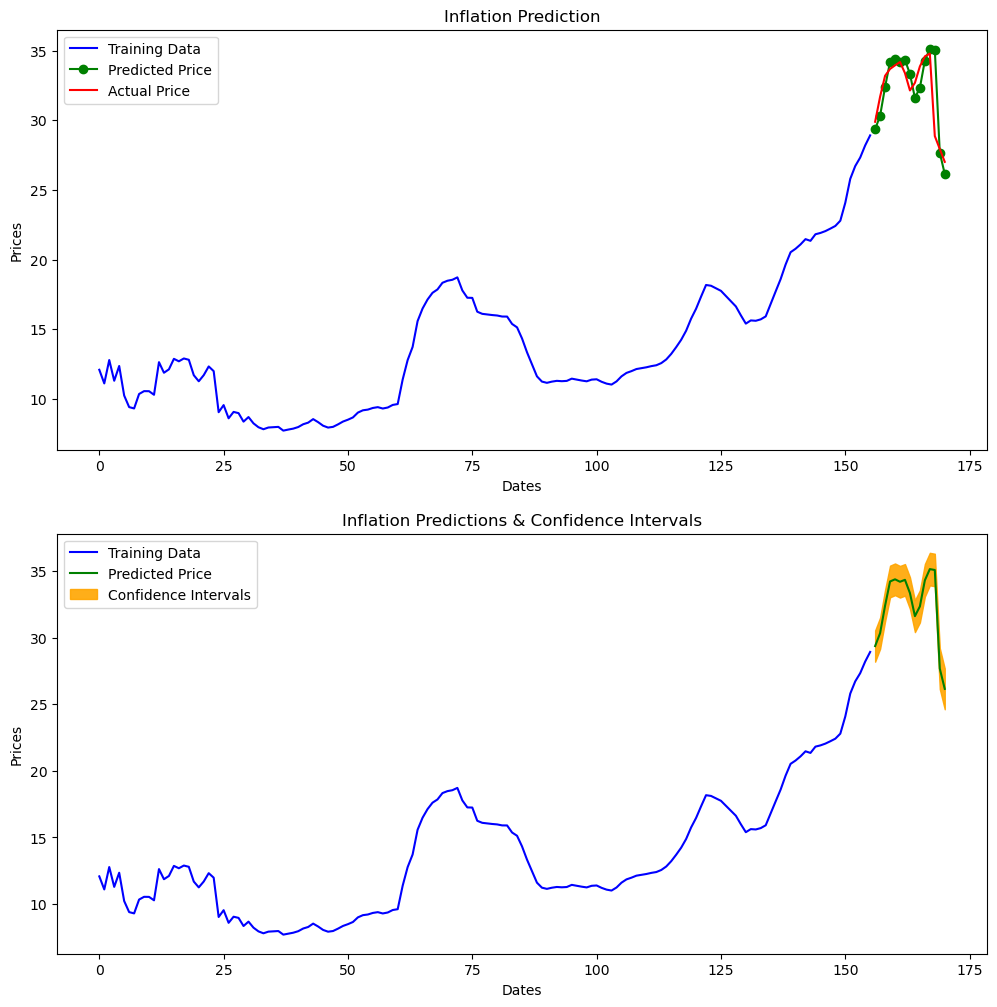

In [35]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Inflation Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

# axes[0].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Inflation Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

# axes[1].set_xticks(np.arange(0, 7982, 1300).tolist(), df['Date'][0:7982:1300].tolist())
axes[1].legend()

In [36]:
# PERFORMANCE BEFORE REBASE (Jan 2024 - Dec 2024)
# first 12 months in the test set

# Get the first 12 months of the test set
metrics_test_ar_baseline_before_rebase = calculate_metrics(y_test[:12], forecasts[:12])

# Create a DataFrame to store the metrics
metrics_test_ar_baseline_before_rebase_df = pd.DataFrame({
    'Model': ['AR Baseline (Test Before Rebase)'],
    'R-squared': [metrics_test_ar_baseline_before_rebase[0]],
    'MSE': [metrics_test_ar_baseline_before_rebase[1]],
    'RMSE': [metrics_test_ar_baseline_before_rebase[2]],
    'RMSPE': [metrics_test_ar_baseline_before_rebase[3]],
    'MAE': [metrics_test_ar_baseline_before_rebase[4]],
    'MAPE': [metrics_test_ar_baseline_before_rebase[-2]],
    'SMAPE': [metrics_test_ar_baseline_before_rebase[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_baseline_before_rebase_df = metrics_test_ar_baseline_before_rebase_df.round(2)
display(metrics_test_ar_baseline_before_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline (Test Before Rebase),0.56,0.77,0.88,2.69,0.75,2.29,2.31


In [37]:
# PERFORMANCE AFTER REBASE
# calculate the metrics for each model for y_test and y_pred last 3 months (Jan - Mar 2025)

metrics_test_ar_baseline_after_rebase = calculate_metrics(y_test[-3:], forecasts[-3:])


# Create a DataFrame to store the metrics
metrics_test_ar_baseline_after_rebase_df = pd.DataFrame({
    'Model': ['AR Baseline (Test Before Rebase)'],
    'R-squared': [metrics_test_ar_baseline_after_rebase[0]],
    'MSE': [metrics_test_ar_baseline_after_rebase[1]],
    'RMSE': [metrics_test_ar_baseline_after_rebase[2]],
    'RMSPE': [metrics_test_ar_baseline_after_rebase[3]],
    'MAE': [metrics_test_ar_baseline_after_rebase[4]],
    'MAPE': [metrics_test_ar_baseline_after_rebase[-2]],
    'SMAPE': [metrics_test_ar_baseline_after_rebase[-1]]
})

# Print the metrics DataFrame
metrics_test_ar_baseline_after_rebase_df = metrics_test_ar_baseline_after_rebase_df.round(2)
display(metrics_test_ar_baseline_after_rebase_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline (Test Before Rebase),-21.88,13.1,3.62,12.55,2.45,8.55,7.88


In [38]:
list_of_dfs = [
    metrics_test_ar_baseline_df,
    metrics_test_ar_baseline_before_rebase_df,
    metrics_test_ar_baseline_after_rebase_df,
]

result_df = pd.concat(list_of_dfs, axis=0)
result_df

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,AR Baseline,0.45,3.24,1.80,6.11,1.09,3.55,3.42
0,AR Baseline (Test Before Rebase),0.56,0.77,0.88,2.69,0.75,2.29,2.31
0,AR Baseline (Test Before Rebase),-21.88,13.10,3.62,12.55,2.45,8.55,7.88


### Compared to the Naive Model, the AR model performs well before the rebase period (a shock relevant to this problem), and underperforms the naive model after the shock. 

# TODO:

- Temporal Split checks for better train-set that is more resilent to shocks
- Adding exogenous data like Google Trends data

## Temporal Split Sensitivity Check with Modified Expanding Window Cross-Validation

In [39]:
inflation_data.head()

,Month,Inflation rate
0,2011-01-01,12.079665
1,2011-02-01,11.099837
2,2011-03-01,12.779128
3,2011-04-01,11.291282
4,2011-05-01,12.352128


In [40]:
# fixed train and test set size but train set size grows over time

# define train and test sizes
train_size = 36
test_size = 24
expansion_window = 12

list_of_ar_dfs = []

month_list = inflation_data['Month']
print(month_list)

# iterate over different temporal splits
for start in range(train_size, len(inflation_data) - test_size, expansion_window):
    y_train = inflation_data['Inflation rate'].iloc[:start]
    y_test = inflation_data['Inflation rate'].iloc[start : start + test_size]
    print(f'train_size: {len(y_train)}, test_size: {len(y_test)}, total: {len(y_train) + len(y_test)}')

    # fit the ARIMA model 
    ar = auto_arima(
                            y_train, 
                            d=n_diffs, 
                            seasonal=False, 
                            stepwise=True,
                            suppress_warnings=True, 
                            error_action="ignore", 
                            max_p=36,
                            max_order=None,
                            information_criterion='aic',
                            # information_criterion='bic',
                            # trace=True,
                            trace=False
                        )

    print(f'(p, d, q): {ar.order}')

    # Predict on the test set
    model = ar  # seeded from the model we've already fit

    def forecast_one_step():
        fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
        return (
            fc.tolist()[0],
            np.asarray(conf_int).tolist()[0])

    forecasts = []
    confidence_intervals = []

    for new_ob in y_test:
        fc, conf = forecast_one_step()
        forecasts.append(fc)
        confidence_intervals.append(conf)

        # Updates the existing model with a small number of MLE steps
        model.update(new_ob)

    # Calculate metrics for the naive baseline
    metrics_test_ar_baseline = calculate_metrics(y_test, forecasts)

    # Get date range
    train_start_date = month_list[0].strftime('%b-%Y')
    train_end_date = month_list[start - 1].strftime('%b-%Y')
    test_start_date = month_list[start].strftime('%b-%Y')
    test_end_date = month_list[start + test_size - 1].strftime('%b-%Y')  # Fixed indexing

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Model': [f'{train_start_date} - {train_end_date}, {test_start_date} - {test_end_date}'],
        'R-squared': [metrics_test_ar_baseline[0]],
        'MSE': [metrics_test_ar_baseline[1]],
        'RMSE': [metrics_test_ar_baseline[2]],
        'RMSPE': [metrics_test_ar_baseline[3]],
        'MAE': [metrics_test_ar_baseline[4]],
        'MAPE': [metrics_test_ar_baseline[-2]],
        'SMAPE': [metrics_test_ar_baseline[-1]]
    })

    # Print the metrics DataFrame
    metrics_df = metrics_df.round(2)
    list_of_ar_dfs.append(metrics_df)

0     2011-01-01
1     2011-02-01
2     2011-03-01
3     2011-04-01
4     2011-05-01
         ...    
166   2024-11-01
167   2024-12-01
168   2025-01-01
169   2025-02-01
170   2025-03-01
Name: Month, Length: 171, dtype: datetime64[ns]
train_size: 36, test_size: 24, total: 60
(p, d, q): (1, 1, 0)
train_size: 48, test_size: 24, total: 72
(p, d, q): (1, 1, 0)
train_size: 60, test_size: 24, total: 84
(p, d, q): (1, 1, 0)
train_size: 72, test_size: 24, total: 96
(p, d, q): (0, 1, 0)
train_size: 84, test_size: 24, total: 108
(p, d, q): (0, 1, 0)
train_size: 96, test_size: 24, total: 120
(p, d, q): (0, 1, 2)
train_size: 108, test_size: 24, total: 132
(p, d, q): (0, 1, 2)
train_size: 120, test_size: 24, total: 144
(p, d, q): (0, 1, 2)
train_size: 132, test_size: 24, total: 156
(p, d, q): (2, 1, 0)
train_size: 144, test_size: 24, total: 168
(p, d, q): (2, 1, 0)


In [41]:
result_df = pd.concat(list_of_ar_dfs, axis=0)
display(result_df)

,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,"Jan-2011 - Dec-2013, Jan-2014 - Dec-2015",0.89,0.04,0.20,2.31,0.17,1.98,2.00
0,"Jan-2011 - Dec-2014, Jan-2015 - Dec-2016",0.96,0.62,0.79,5.93,0.52,4.00,4.19
0,"Jan-2011 - Dec-2015, Jan-2016 - Dec-2017",0.86,0.70,0.84,6.02,0.57,3.88,4.04
0,"Jan-2011 - Dec-2016, Jan-2017 - Dec-2018",0.96,0.24,0.49,3.51,0.34,2.39,2.33
0,"Jan-2011 - Dec-2017, Jan-2018 - Dec-2019",0.85,0.15,0.39,3.12,0.26,2.12,2.08
0,"Jan-2011 - Dec-2018, Jan-2019 - Dec-2020",0.95,0.07,0.27,1.93,0.19,1.49,1.51
0,"Jan-2011 - Dec-2019, Jan-2020 - Dec-2021",0.97,0.15,0.39,2.43,0.33,2.10,2.12
0,"Jan-2011 - Dec-2020, Jan-2021 - Dec-2022",0.94,0.21,0.46,2.62,0.39,2.23,2.25
0,"Jan-2011 - Dec-2021, Jan-2022 - Dec-2023",0.98,0.27,0.52,2.40,0.38,1.79,1.82
0,"Jan-2011 - Dec-2022, Jan-2023 - Dec-2024",0.98,0.56,0.75,2.51,0.58,1.95,1.97


#### Modifying the Expanding Window System to include the shock/rebase period for better analysis

In [42]:
## Train split + Test Split = len of full dataset
## Train split grows while Test shrinks but the focus in the metric for the test split after rebase

# define train and test sizes
train_size = 36
min_test_size = 15 # one year + Q1 2025
# expansion_window = 12
expansion_window = 3 # quarterly shifts

month_list = inflation_data['Month']
print(month_list)

list_of_ar_dfs_modified = []
list_of_ar_dfs_before_rebase = []
list_of_ar_dfs_after_rebase = []

# iterate over different temporal splits
for start in range(train_size, len(inflation_data) + 1 - min_test_size, expansion_window):
    y_train = inflation_data['Inflation rate'].iloc[:start]
    y_test = inflation_data['Inflation rate'].iloc[start : len(inflation_data) + 1]
    print(f'train_size: {len(y_train)}, test_size: {len(y_test)}, total: {len(y_train) + len(y_test)}')

    # fit the ARIMA model 
    ar = auto_arima(
                            y_train, 
                            d=n_diffs, 
                            seasonal=False, 
                            stepwise=True,
                            suppress_warnings=True, 
                            error_action="ignore", 
                            max_p=36,
                            max_order=None,
                            information_criterion='aic',
                            # information_criterion='bic',
                            # trace=True,
                            trace=False
                        )

    print(f'(p, d, q): {ar.order}')

    # Predict on the test set
    model = ar  # seeded from the model we've already fit

    def forecast_one_step():
        fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
        return (
            fc.tolist()[0],
            np.asarray(conf_int).tolist()[0])

    forecasts = []
    confidence_intervals = []

    for new_ob in y_test:
        fc, conf = forecast_one_step()
        forecasts.append(fc)
        confidence_intervals.append(conf)

        # Updates the existing model with a small number of MLE steps
        model.update(new_ob)

    # Calculate metrics for the naive baseline
    metrics_test_ar_baseline = calculate_metrics(y_test, forecasts)

    # Get date range
    train_start_date = month_list[0].strftime('%b-%Y')
    train_end_date = month_list[start - 1].strftime('%b-%Y')
    test_start_date = month_list[start].strftime('%b-%Y')
    test_end_date = month_list[len(inflation_data) - 1].strftime('%b-%Y')
    # print(test_end_date)

    # Create a DataFrame to store the metrics
    metrics_df = pd.DataFrame({
        'Model': [f'{train_start_date} - {train_end_date}, {test_start_date} - {test_end_date}'],
        'R-squared': [metrics_test_ar_baseline[0]],
        'MSE': [metrics_test_ar_baseline[1]],
        'RMSE': [metrics_test_ar_baseline[2]],
        'RMSPE': [metrics_test_ar_baseline[3]],
        'MAE': [metrics_test_ar_baseline[4]],
        'MAPE': [metrics_test_ar_baseline[-2]],
        'SMAPE': [metrics_test_ar_baseline[-1]]
    })
    metrics_df = metrics_df.round(2)
    # display(metrics_df)
    list_of_ar_dfs_modified.append(metrics_df)

    metrics_test_before_rebase = calculate_metrics(y_test[:-3], forecasts[:-3])
    metrics_test_before_rebase_df = pd.DataFrame({
        'Model': [f'{train_start_date} - {train_end_date}'],
        'R-squared': [metrics_test_before_rebase[0]],
        'MSE': [metrics_test_before_rebase[1]],
        'RMSE': [metrics_test_before_rebase[2]],
        'RMSPE': [metrics_test_before_rebase[3]],
        'MAE': [metrics_test_before_rebase[4]],
        'MAPE': [metrics_test_before_rebase[-2]],
        'SMAPE': [metrics_test_before_rebase[-1]]
    })
    metrics_test_before_rebase_df = metrics_test_before_rebase_df.round(2)
    list_of_ar_dfs_before_rebase.append(metrics_test_before_rebase_df)


    metrics_test_after_rebase = calculate_metrics(y_test[-3:], forecasts[-3:])
    metrics_test_after_rebase_df = pd.DataFrame({
        'Model': [f'{train_start_date} - {train_end_date}'],
        'R-squared': [metrics_test_after_rebase[0]],
        'MSE': [metrics_test_after_rebase[1]],
        'RMSE': [metrics_test_after_rebase[2]],
        'RMSPE': [metrics_test_after_rebase[3]],
        'MAE': [metrics_test_after_rebase[4]],
        'MAPE': [metrics_test_after_rebase[-2]],
        'SMAPE': [metrics_test_after_rebase[-1]]
    })
    metrics_test_after_rebase_df = metrics_test_after_rebase_df.round(2)
    list_of_ar_dfs_after_rebase.append(metrics_test_after_rebase_df)

0     2011-01-01
1     2011-02-01
2     2011-03-01
3     2011-04-01
4     2011-05-01
         ...    
166   2024-11-01
167   2024-12-01
168   2025-01-01
169   2025-02-01
170   2025-03-01
Name: Month, Length: 171, dtype: datetime64[ns]
train_size: 36, test_size: 135, total: 171
(p, d, q): (1, 1, 0)
train_size: 39, test_size: 132, total: 171
(p, d, q): (1, 1, 0)
train_size: 42, test_size: 129, total: 171
(p, d, q): (1, 1, 0)
train_size: 45, test_size: 126, total: 171
(p, d, q): (1, 1, 0)
train_size: 48, test_size: 123, total: 171
(p, d, q): (1, 1, 0)
train_size: 51, test_size: 120, total: 171
(p, d, q): (1, 1, 0)
train_size: 54, test_size: 117, total: 171
(p, d, q): (1, 1, 0)
train_size: 57, test_size: 114, total: 171
(p, d, q): (1, 1, 0)
train_size: 60, test_size: 111, total: 171
(p, d, q): (1, 1, 0)
train_size: 63, test_size: 108, total: 171
(p, d, q): (0, 1, 0)
train_size: 66, test_size: 105, total: 171
(p, d, q): (0, 1, 0)
train_size: 69, test_size: 102, total: 171
(p, d, q): (0, 1, 

In [43]:
result_full_df = pd.concat(list_of_ar_dfs_modified, axis=0)
display(result_full_df)
result_before_rebase_df = pd.concat(list_of_ar_dfs_before_rebase, axis=0)
display(result_before_rebase_df)
result_after_rebase_df = pd.concat(list_of_ar_dfs_after_rebase, axis=0)
display(result_after_rebase_df)



,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,"Jan-2011 - Dec-2013, Jan-2014 - Mar-2025",0.99,0.59,0.77,3.95,0.44,2.58,2.61
0,"Jan-2011 - Mar-2014, Apr-2014 - Mar-2025",0.99,0.60,0.78,3.99,0.45,2.61,2.64
0,"Jan-2011 - Jun-2014, Jul-2014 - Mar-2025",0.99,0.62,0.78,4.02,0.45,2.63,2.65
0,"Jan-2011 - Sep-2014, Oct-2014 - Mar-2025",0.99,0.63,0.79,4.05,0.46,2.64,2.66
0,"Jan-2011 - Dec-2014, Jan-2015 - Mar-2025",0.99,0.64,0.80,4.08,0.47,2.65,2.67
0,"Jan-2011 - Mar-2015, Apr-2015 - Mar-2025",0.99,0.66,0.81,4.11,0.47,2.65,2.67
0,"Jan-2011 - Jun-2015, Jul-2015 - Mar-2025",0.99,0.67,0.82,4.12,0.48,2.63,2.66
0,"Jan-2011 - Sep-2015, Oct-2015 - Mar-2025",0.99,0.69,0.83,4.17,0.49,2.67,2.70
0,"Jan-2011 - Dec-2015, Jan-2016 - Mar-2025",0.98,0.71,0.84,4.22,0.50,2.71,2.74
0,"Jan-2011 - Mar-2016, Apr-2016 - Mar-2025",0.98,0.72,0.85,3.82,0.52,2.65,2.65


,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,Jan-2011 - Dec-2013,0.99,0.32,0.57,3.55,0.39,2.44,2.48
0,Jan-2011 - Mar-2014,0.99,0.33,0.57,3.58,0.40,2.47,2.51
0,Jan-2011 - Jun-2014,0.99,0.34,0.58,3.60,0.40,2.48,2.52
0,Jan-2011 - Sep-2014,0.99,0.34,0.59,3.63,0.41,2.49,2.52
0,Jan-2011 - Dec-2014,0.99,0.35,0.59,3.65,0.42,2.49,2.53
0,Jan-2011 - Mar-2015,0.99,0.36,0.60,3.67,0.42,2.49,2.53
0,Jan-2011 - Jun-2015,0.99,0.37,0.60,3.68,0.42,2.47,2.51
0,Jan-2011 - Sep-2015,0.99,0.37,0.61,3.72,0.43,2.51,2.55
0,Jan-2011 - Dec-2015,0.99,0.38,0.62,3.77,0.44,2.54,2.59
0,Jan-2011 - Mar-2016,0.99,0.39,0.63,3.29,0.46,2.47,2.49


,Model,R-squared,MSE,RMSE,RMSPE,MAE,MAPE,SMAPE
0,Jan-2011 - Dec-2013,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Mar-2014,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Jun-2014,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Sep-2014,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Dec-2014,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Mar-2015,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Jun-2015,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Sep-2015,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Dec-2015,-20.62,12.37,3.52,12.20,2.52,8.83,8.18
0,Jan-2011 - Mar-2016,-20.44,12.27,3.50,12.16,2.59,9.09,8.41


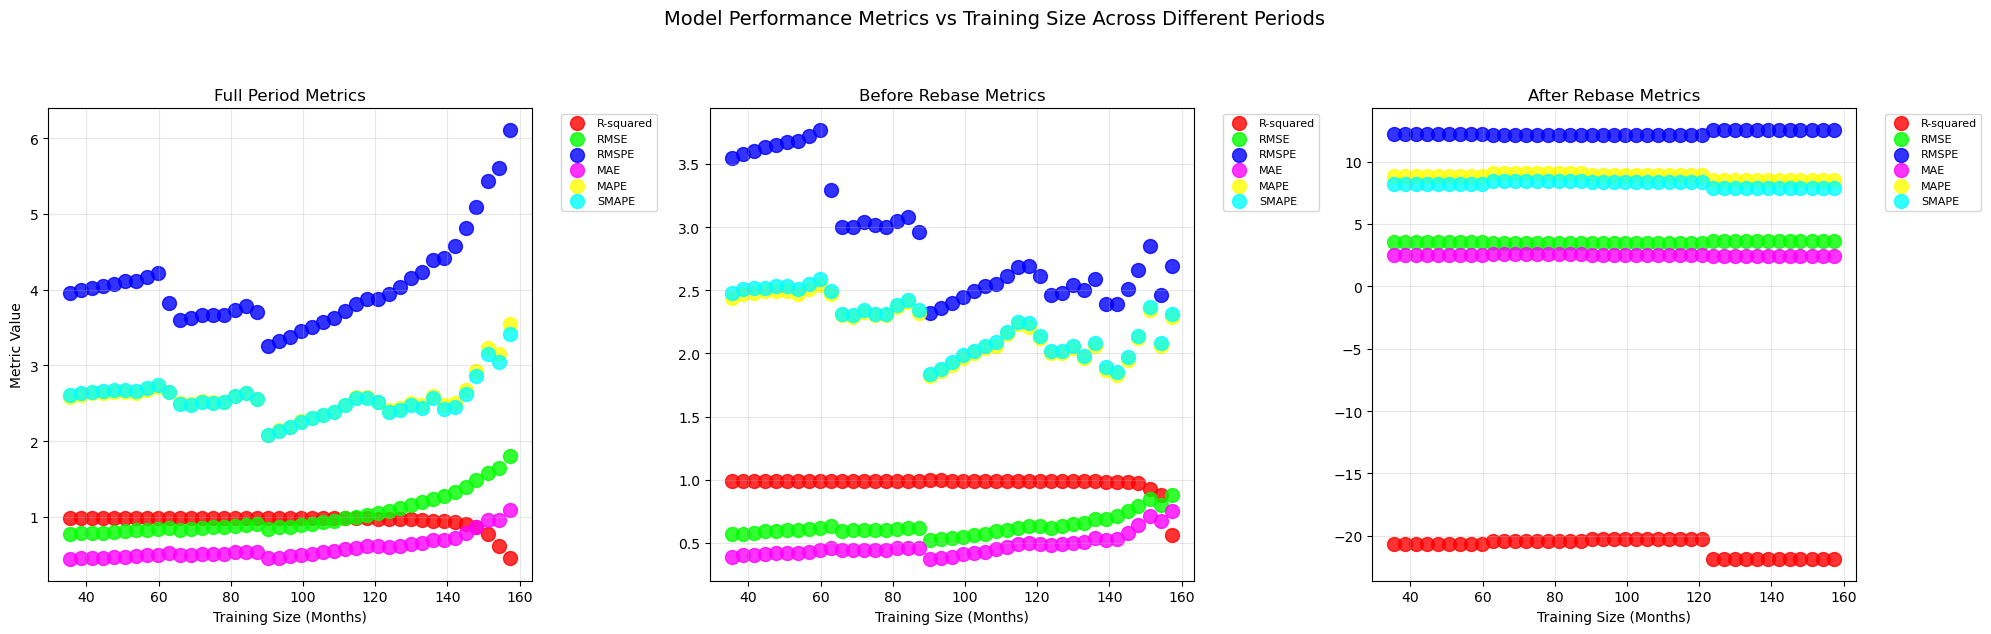

In [44]:
# Extract train sizes and create three subplots for different periods
import matplotlib.pyplot as plt
import seaborn as sns

def extract_train_size(model_name):
    train_period = model_name.split(',')[0] if ',' in model_name else model_name
    start_date = pd.to_datetime(train_period.split(' - ')[0])
    end_date = pd.to_datetime(train_period.split(' - ')[1])
    return (end_date - start_date).days / 30  # Approximate months

# Add train size columns to all DataFrames
result_full_df['Train Size (Months)'] = result_full_df['Model'].apply(extract_train_size)
result_before_rebase_df['Train Size (Months)'] = result_before_rebase_df['Model'].apply(extract_train_size)
result_after_rebase_df['Train Size (Months)'] = result_after_rebase_df['Model'].apply(extract_train_size)

# Create figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Define metrics and colors
metrics = ['R-squared', 'RMSE', 'RMSPE', 'MAE', 'MAPE', 'SMAPE']
colors = ['#FF0000', '#00FF00', '#0000FF', '#FF00FF', '#FFFF00', '#00FFFF']

# Plot for full period
for metric, color in zip(metrics, colors):
    ax1.scatter(result_full_df['Train Size (Months)'], 
               result_full_df[metric], 
               label=metric, 
               alpha=0.8,
               c=color,
               s=100)
ax1.set_title('Full Period Metrics', fontsize=12)
ax1.set_xlabel('Training Size (Months)')
ax1.set_ylabel('Metric Value')
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot for before rebase
for metric, color in zip(metrics, colors):
    ax2.scatter(result_before_rebase_df['Train Size (Months)'], 
               result_before_rebase_df[metric], 
               label=metric, 
               alpha=0.8,
               c=color,
               s=100)
ax2.set_title('Before Rebase Metrics', fontsize=12)
ax2.set_xlabel('Training Size (Months)')
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Plot for after rebase
for metric, color in zip(metrics, colors):
    ax3.scatter(result_after_rebase_df['Train Size (Months)'], 
               result_after_rebase_df[metric], 
               label=metric, 
               alpha=0.8,
               c=color,
               s=100)
ax3.set_title('After Rebase Metrics', fontsize=12)
ax3.set_xlabel('Training Size (Months)')
ax3.grid(True, alpha=0.3)
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Add overall title
fig.suptitle('Model Performance Metrics vs Training Size Across Different Periods', 
             fontsize=14, y=1.05)

# Adjust layout
plt.tight_layout()
plt.show()

#### Based on RMSPE and SMAPE after rebase, the following train-test split are good candidates for further exploration

- Jan 2011 - Jun 2018 | Jul 2018 - Mar 2025 (from above) with n_diff = 1
<!-- - Jan 2011 - Dec 2023 | Jan 2024 - Mar 2025 (initial decision) -->